In [95]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv', index_col= ['id'])
test = pd.read_csv('test.csv', index_col= ['id'])

def drop(df): 
    for_dropping = ['Surname','CustomerId'] #Take CustomerId out to see the analysis of recurring CustomerIds
    df = df.drop(for_dropping, axis = 1)
    return df
train, test = drop(train), drop(test)

from sklearn.preprocessing import LabelEncoder
def encode_categories(df): 
    encoder = LabelEncoder()
    columns_for_encoding = ['Geography','Gender']
    for col in columns_for_encoding: 
        df[col] = encoder.fit_transform(df[col])
    return df
train, test = encode_categories(train), encode_categories(test)

def smote_prep(df): 
    df['HasCrCard'] = df['HasCrCard'].astype(int)
    df['IsActiveMember'] = df['IsActiveMember'].astype(int)
    return df
train, test = smote_prep(train), smote_prep(test)

train.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,
0,668,0,1,33.0,3,0.0,2,1,0,181449.97,0
1,627,0,1,33.0,1,0.0,2,1,1,49503.50,0
2,678,0,1,40.0,10,0.0,2,1,0,184866.69,0


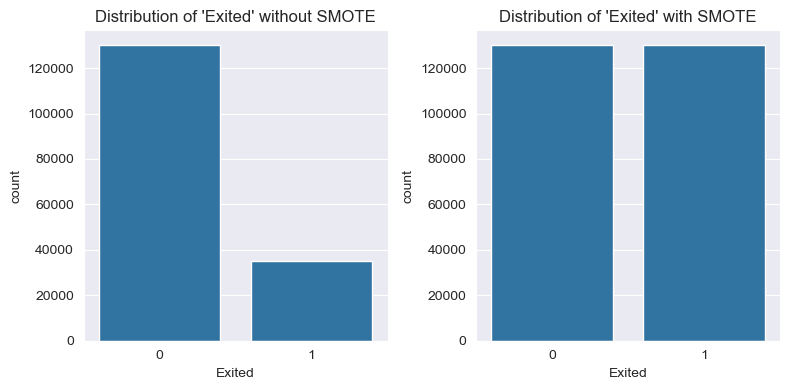

In [96]:
from imblearn.over_sampling import SMOTE
sns.set_style('darkgrid')
X = train.copy().drop(['Exited'], axis =1 )
y = train['Exited']

X_resampled, y_resampled = SMOTE(random_state= 1, sampling_strategy= 'minority').fit_resample(X, y)

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.countplot(x = y, ax= ax[0]).set_title('Distribution of \'Exited\' without SMOTE')
sns.countplot(x = y_resampled, ax = ax[1]).set_title('Distribution of \'Exited\' with SMOTE')
plt.tight_layout()
plt.show()

In [97]:
print('--- COMPARISON OF UNSAMPLED AND RESAMPLED DATAFRAMES ---\n')

print('ORIGINAL STATISTICS')
display(X.describe().loc[['mean','std'], :].round(2))
print()
print('RESAMPLED STATISTICS')
display(X_resampled.describe().loc[['mean','std'], :].round(2))

--- COMPARISON OF UNSAMPLED AND RESAMPLED DATAFRAMES ---

ORIGINAL STATISTICS


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
mean,656.45,0.65,0.56,38.13,5.02,55478.09,1.55,0.75,0.5,112574.82
std,80.10,0.82,0.50,8.87,2.81,62817.66,0.55,0.43,0.5,50292.87



RESAMPLED STATISTICS


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
mean,654.65,0.60,0.43,40.26,4.82,61234.02,1.40,0.68,0.35,113167.24
std,76.41,0.74,0.49,8.83,2.65,63231.69,0.53,0.47,0.48,50384.46


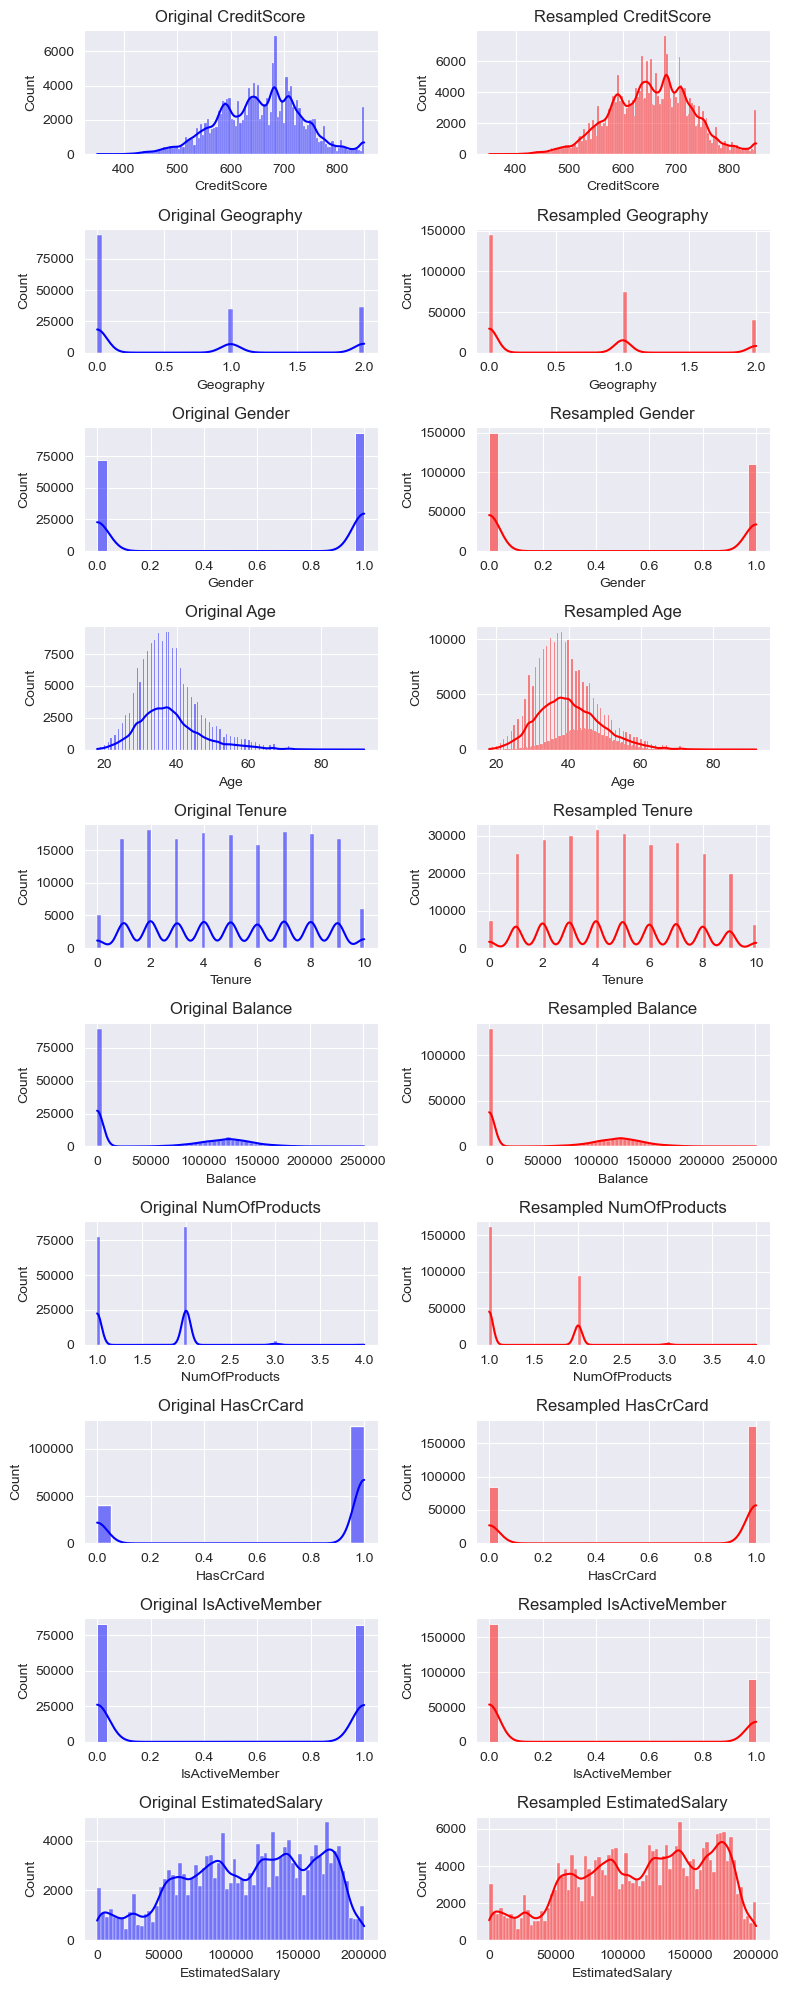

In [63]:
#COMPARING DISTRIBUTIONS

idx = len(X.columns)
fig, axes = plt.subplots(idx, 2, figsize = (8, idx * 2))

for i, col in enumerate(X.columns): 
    sns.histplot(X[col], ax = axes[i, 0], kde = True, color = 'blue')
    sns.histplot(X_resampled[col], ax = axes[i, 1], kde = True, color = 'red')
    axes[i, 0].set_title(f'Original {col}')
    axes[i, 1].set_title(f'Resampled {col}')
plt.tight_layout()
plt.show()

In [98]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler(feature_range= (-1, 1)) 
X_resampled_scaled = scaler.fit_transform(X_resampled)

X_train, X_val, y_train, y_val = train_test_split(X_resampled_scaled, y_resampled, test_size= 0.2, shuffle= True, random_state= 1)

In [49]:
#Using the top 3 performing models of the bank.ipynb file
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

classifiers = [GradientBoostingClassifier(random_state= 1), 
               MLPClassifier(random_state= 1), 
               XGBClassifier(random_state = 1)]

classifier_dict = dict()
for clf in classifiers: 
        clf_name = clf.__class__.__name__
        scores = cross_val_score(clf, X_resampled_scaled, y_resampled, cv=5, scoring='roc_auc')
        classifier_dict[clf_name] = round(scores.mean(), 4)
    
score_df = pd.DataFrame(classifier_dict.items(), columns = ['Classifier','ROC AUC']).sort_values(by = 'ROC AUC', ascending= False)
score_df

,Classifier,ROC AUC
2,XGBClassifier,0.9555
0,GradientBoostingClassifier,0.9387
1,MLPClassifier,0.9319


In [67]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold 

cv = KFold(n_splits= 5, shuffle= True, random_state= 1)
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [1e-3, 1e-2, 1e-1, 1],
    'booster': ['gbtree', 'dart'],
    'gamma': [0, 1e-3, 1e-2, 1e-1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 1e-2, 1e-1, 1],
    'reg_lambda': [0, 1e-2, 1e-1, 1],
    'scale_pos_weight': [1, 10, 50]
}

xgb = XGBClassifier(random_state = 1, objective = 'binary:logistic', eval_metric = 'auc')

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions= param_grid, 
    n_iter = 50, 
    cv = cv, 
    scoring = 'roc_auc', 
    n_jobs = -1, 
    random_state = 1
)

search = random_search.fit(X_train, y_train)
print("Best Parameters:", search.best_params_)
print("Best ROC AUC Score:", search.best_score_)

Best Parameters: {'subsample': 1.0, 'scale_pos_weight': 1, 'reg_lambda': 0.01, 'reg_alpha': 1, 'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0, 'booster': 'dart'}
Best ROC AUC Score: 0.9573110280260183


In [92]:
#Simple model 
test_scaled = scaler.fit_transform(test)

simple_xgb = XGBClassifier(random_state = 1)
simple_xgb.fit(X_resampled_scaled, y_resampled)
final_pred_xgb = simple_xgb.predict(test_scaled)

df_xgb = pd.DataFrame(final_pred_xgb, index = test.index, columns = ['Exited'])
#df_xgb.to_csv('xgb_smote_simple_v1.csv')

In [94]:
advanced_xgb = XGBClassifier(
    random_state = 1, 
    subsample = 1, 
    scale_pos_weight = 1, 
    reg_lambda = 0.01, 
    reg_alpha = 1, 
    n_estimators = 150, 
    max_depth = 15, 
    learning_rate = 0.1, 
    gamma = 0, 
    colsample_bytree = 1, 
    booster = 'dart'
)

advanced_xgb.fit(X_resampled_scaled, y_resampled)
final_pred_advanced_xgb = advanced_xgb.predict(test_scaled)

df_advanced_xgb = pd.DataFrame(final_pred_advanced_xgb, index = test.index, columns = ['Exited'])
#df_xgb.to_csv('xgb_smote_advanced_v1.csv')